In [ ]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import scipy.stats as ss
import shutil
import time


from datetime import datetime
from itertools import product
from scipy.spatial.distance import cdist
from shapely import Point, LineString
from geopy.distance import geodesic
from shapely.strtree import STRtree
from sklearn.cluster import DBSCAN

In [ ]:
BASE_DIR = 'D:/Desktop/mobility-seoul/'  # Change this to your base directory!
URBAN_CROPPED_DIR = os.path.join(BASE_DIR, 'Data/GIS data/Urban cropped/')

In [ ]:
cozie_df = pd.read_csv(os.path.join(BASE_DIR, 'Data/Participant data/arda_survey_results_select_en.csv'), header = 0)
cozie_df.drop('Unnamed: 0', axis=1, inplace=True)

C:\Users\Michele\AppData\Local\Temp\ipykernel_15480\596002054.py:3: DtypeWarning: Columns (2,3,4,5,6,7,8,10,15,16,17,18,19,22,23,33,35,47,72,76,77,78,79) have mixed types. Specify dtype option on import or set low_memory=False.
  cozie_df = pd.read_csv(os.path.join(base_dir, 'Data/Participant data/arda_survey_results_select_en.csv'), header = 0)


In [3]:
# removing columns that are not needed
cozie_df.drop(['si_iphone_location_service_enabled', 'si_watch_location_service_enabled', 'ts_location_acquisition_method',
                  'ts_location_floor', 'ts_location_source_device', 'ws_location_acquisition_method', 'ws_location_floor',
                  'ws_location_source_device', 'wss_goal', 'wss_participation_days', 'wss_participation_time_end', 
                  'wss_participation_time_start', 'wss_reminder_enabeled', 'wss_reminder_interval', 'ts_HRV', 'ts_audio_exposure_environment', 
                  'ts_audio_exposure_headphones', 'ts_heart_rate', 'ts_oxygen_saturation', 'ts_resting_heart_rate', 'ts_sleep_REM', 'ts_sleep_awake',
                  'ts_sleep_core', 'ts_sleep_deep', 'ts_sleep_in_bed', 'ts_sleep_unspecified', 'ts_stand_time', 'ts_step_count', 'ts_walking_distance',
                  'ws_HRV', 'ws_audio_exposure_environment', 'ws_audio_exposure_headphones', 'ws_heart_rate', 'ws_oxygen_saturation', 
                  'ws_resting_heart_rate', 'ws_sleep_REM', 'ws_sleep_awake', 'ws_sleep_core', 'ws_sleep_deep', 'ws_sleep_in_bed', 'ws_sleep_unspecified',
                  'ws_stand_time', 'ws_step_count', 'ws_walking_distance', 'wss_time_out'], axis=1, inplace=True)

# removing additional columns that (should) not be needed
cozie_df.drop(['q_clothing', 'q_mood', ], axis=1, inplace=True)

print(cozie_df.columns) #printing column names

Index(['id_participant', 'location_change', 'q_activity_change_leisure',
       'q_activity_change_meal', 'q_activity_change_other',
       'q_activity_change_outdoors', 'q_activity_change_studying',
       'q_activity_change_working', 'q_activity_indoors',
       'q_activity_outdoors', 'q_adaptive_comfort', 'q_location',
       'q_location_change', 'q_location_leisure', 'q_location_meal',
       'q_location_other', 'q_location_studying', 'q_location_working',
       'q_thermal', 'timestamp', 'ts_altitude', 'ts_latitude',
       'ts_location_accuracy_horizontal', 'ts_location_accuracy_vertical',
       'ts_longitude', 'ts_timestamp_location', 'ws_altitude', 'ws_latitude',
       'ws_location_accuracy_horizontal', 'ws_location_accuracy_vertical',
       'ws_longitude', 'ws_survey_count', 'ws_timestamp_location',
       'ws_timestamp_start', 'wss_title'],
      dtype='object')


In [4]:
# replacing 0.0 coordinate value with NaN
cozie_df[['ts_longitude', 'ws_longitude', 'ts_latitude', 'ws_latitude']] = cozie_df[['ts_longitude', 'ws_longitude', 'ts_latitude', 'ws_latitude']].astype(float)
cozie_df[['ts_longitude', 'ws_longitude', 'ts_latitude', 'ws_latitude']] = cozie_df[['ts_longitude', 'ws_longitude', 'ts_latitude', 'ws_latitude']].replace({0: np.nan})

In [5]:
# dealing with timestamps
cozie_df['datetime'] = pd.to_datetime(cozie_df.timestamp, format='ISO8601')
cozie_df['date'] = cozie_df['datetime'].dt.date

cozie_df['datetime_ts_location'] = pd.to_datetime(cozie_df.ts_timestamp_location, format='ISO8601')
cozie_df['datetime_ws_location'] = pd.to_datetime(cozie_df.ws_timestamp_location, format='ISO8601')

cozie_df['merged_datetime'] = cozie_df['datetime_ts_location'].combine_first(cozie_df['datetime_ws_location'])
cozie_df['merged_date'] = cozie_df['merged_datetime'].dt.date

In [6]:
# dropping rows that are not needed 

# drop the Weather (short) wss title value
cozie_df.drop(cozie_df.loc[cozie_df.wss_title == 'Weather (short)'].index, inplace=True)

# drop rows with all null values
cozie_df = cozie_df.loc[cozie_df[
    ['location_change', 'q_activity_change_leisure', 'q_activity_change_meal', 'q_activity_change_other', 'q_activity_change_outdoors',
     'q_activity_change_studying', 'q_activity_change_working', 'q_activity_indoors', 'q_activity_outdoors', 'q_adaptive_comfort',
     'q_location', 'q_location_change', 'q_location_leisure', 'q_location_meal', 'q_location_other', 'q_location_studying',
     'q_location_working', 'q_thermal', 'ts_altitude', 'ts_latitude', 'ts_location_accuracy_horizontal', 'ts_location_accuracy_vertical', 
     'ts_longitude', 'ts_timestamp_location', 'ws_altitude', 'ws_latitude', 'ws_location_accuracy_horizontal', 'ws_location_accuracy_vertical', 
     'ws_longitude', 'ws_survey_count', 'ws_timestamp_location', 'ws_timestamp_start']].dropna(how='all').index].reset_index(drop=True)

# drop rows with no coordinates AND no Cozie survey
cozie_df = cozie_df.loc[cozie_df[
    ['q_activity_change_leisure', 'q_activity_change_meal', 'q_activity_change_other', 'q_activity_change_outdoors',
     'q_activity_change_studying', 'q_activity_change_working', 'q_activity_indoors', 'q_activity_outdoors', 'q_adaptive_comfort',
     'q_location', 'q_location_change', 'q_location_leisure', 'q_location_meal', 'q_location_other', 'q_location_studying',
     'q_location_working', 'q_thermal', 'ts_latitude', 'ts_longitude', 'ws_latitude', 'ws_longitude']].dropna(how='all').index] \
    .reset_index(drop=True)

# drop rows with no coordinates
cozie_df = cozie_df.loc[cozie_df[
    [ 'ts_latitude', 'ts_longitude', 'ws_latitude', 'ws_longitude']].dropna(how='all').index] \
    .reset_index(drop=True)

In [7]:
# creating new fields

# combining ts and ws latitude and longitude into new coordinate columns
cozie_df['latitude'] = np.where(cozie_df['ts_latitude'].notna(), cozie_df['ts_latitude'], cozie_df['ws_latitude'])
cozie_df['longitude'] = np.where(cozie_df['ts_longitude'].notna(), cozie_df['ts_longitude'], cozie_df['ws_longitude'])

cozie_df['latitude'] = cozie_df['latitude'].astype(float)
cozie_df['longitude'] = cozie_df['longitude'].astype(float)

# field for ws/ts coordinate source
cozie_df['coordinate_source'] = np.where(cozie_df['ts_latitude'].notna(), 'ts', 'ws')
cozie_df['source_change'] = cozie_df['coordinate_source'] == cozie_df['coordinate_source'].shift()

# dataset time range fields
start_date = cozie_df['date'].min()
end_date = cozie_df['date'].max()
total_weeks = (end_date - start_date).days  # number of complete weeks
unique_months = cozie_df['merged_datetime'].dt.strftime('%Y-%m').unique()

# single field with a location value
cozie_df['location'] = cozie_df[
    ['q_location_leisure', 'q_location_meal', 'q_location_other', 'q_location_studying', 'q_location_working']
].apply(lambda row: row.dropna().iloc[0] if not row.dropna().empty else None, axis=1)

In [8]:
# some basic information about the raw data:
print(f'Number of records: {cozie_df.shape[0]}') 
print(f"Data spans {(end_date - start_date).days} days from {start_date} to {end_date}")
print(f"Total weeks covered: {total_weeks}")
print(f"Months covered: {', '.join(unique_months)}")

Number of records: 54322
Data spans 51 days from 2023-10-04 to 2023-11-24
Total weeks covered: 51
Months covered: 2023-10, 2023-11


# __Dataset Cleaning__

### Filtering 1: removing reduntant rows

In [9]:
# keeping only the non-reduntant coordinate information
# rows are deemed non-redunant if enough time (time threshold) has passed since the last record from the same participant 

cozie_df = cozie_df.sort_values(by=['id_participant', 'merged_datetime'])
time_threshold = pd.Timedelta(seconds=60*5) # 5 minutes

# defining a few fields to compare each coord with its previous one
cozie_df['prev_lat'] = cozie_df.groupby('id_participant')['latitude'].shift()
cozie_df['prev_lon'] = cozie_df.groupby('id_participant')['longitude'].shift()
cozie_df['prev_time'] = cozie_df.groupby('id_participant')['merged_datetime'].shift()
cozie_df['time_diff'] = (cozie_df['merged_datetime'] - cozie_df['prev_time']).dt.total_seconds()
cozie_df['geo_distance'] = cozie_df.apply(
    lambda row: geodesic((row['latitude'], row['longitude']), 
                         (row['prev_lat'], row['prev_lon'])
                        ).meters if pd.notnull(row['prev_lat']) and pd.notnull(row['prev_lon']) else 0,
    axis=1
)

# identify non-redundant rows
non_redundant_df = cozie_df[
    (cozie_df['id_participant'] != cozie_df['id_participant'].shift()) |                          # keep first occurrence per participant
    (cozie_df['merged_datetime'].sub(cozie_df['merged_datetime'].shift()).abs() > time_threshold) # keep rows outside threshold
].copy()

print(f"Total rows before filtering 1: {len(cozie_df)}")
print(f"Total distinct positions (after removing redundant ones): {len(non_redundant_df)}")

Total rows before filtering 1: 54322
Total distinct positions (after removing redundant ones): 10181


In [10]:
# re-calculating the previous-coordinate fields after keeping only non-redundant rows
non_redundant_df['prev_lat'] = non_redundant_df.groupby('id_participant')['latitude'].shift()
non_redundant_df['prev_lon'] = non_redundant_df.groupby('id_participant')['longitude'].shift()
non_redundant_df['prev_time'] = non_redundant_df.groupby('id_participant')['merged_datetime'].shift()
non_redundant_df['time_diff'] = (non_redundant_df['merged_datetime'] - non_redundant_df['prev_time']).dt.total_seconds()
non_redundant_df['geo_distance'] = non_redundant_df.apply(
    lambda row: geodesic((row['latitude'], row['longitude']), 
                         (row['prev_lat'], row['prev_lon'])
                        ).meters if pd.notnull(row['prev_lat']) and pd.notnull(row['prev_lon']) else 0,
    axis=1
)

### Filtering 2: Removing positions with no change in coordinates

In [ ]:
# records where the coordinates are IDENTICAL to the previous record, but with a location change being indicated are removed
non_redundant_df['same_coordinates'] = (non_redundant_df['latitude'] == non_redundant_df['prev_lat']) & \
                                       (non_redundant_df['longitude'] == non_redundant_df['prev_lon'])

# conditions for removal
conditions = (
    (non_redundant_df['same_coordinates']) &
    ((non_redundant_df['q_location_change'].isin(['Yes, less than 15 min', 'Yes, less than 30 min', 'Yes, less than 45 min', 'Yes, more than 40 min'])) |
        (non_redundant_df['location_change'] == True))
)

filtered_df = non_redundant_df[conditions == False]

# drop the temporary 'same_coordinates' column
filtered_df = filtered_df.drop(columns=['same_coordinates'])

# print the number of records before and after filtering
print(f"Number of records before filtering 2: {len(non_redundant_df)}")
print(f"Number of records after filtering 2: {len(filtered_df)}")
print(f"Total deleted rows by filtering 2: {len(non_redundant_df) - len(filtered_df)}")

Number of records before filtering 2: 10181
Number of records after filtering 2: 10149
Total deleted rows by filtering 2: 32


In [12]:
filtered_df['prev_lat'] = filtered_df.groupby('id_participant')['latitude'].shift()
filtered_df['prev_lon'] = filtered_df.groupby('id_participant')['longitude'].shift()
filtered_df['prev_time'] = filtered_df.groupby('id_participant')['merged_datetime'].shift()
filtered_df['time_diff'] = (filtered_df['merged_datetime'] - filtered_df['prev_time']).dt.total_seconds()
filtered_df['geo_distance'] = filtered_df.apply(
    lambda row: geodesic((row['latitude'], row['longitude']), 
                         (row['prev_lat'], row['prev_lon'])
                        ).meters if pd.notnull(row['prev_lat']) and pd.notnull(row['prev_lon']) else 0,
    axis=1
)

### Filtering 3

In [13]:
# getting the coordinates and timestamp of next location
filtered_df['next_lat'] = filtered_df.groupby('id_participant')['latitude'].shift(-1)
filtered_df['next_lon'] = filtered_df.groupby('id_participant')['longitude'].shift(-1)
filtered_df['next_time'] = filtered_df.groupby('id_participant')['merged_datetime'].shift(-1)

# distance from current to next location
filtered_df['next_geo_distance'] = filtered_df.groupby('id_participant')['geo_distance'].shift(-1)

# distance from previous to next location
filtered_df['prev_next_geo_distance'] = filtered_df.apply(
    lambda row: geodesic((row['prev_lat'], row['prev_lon']),
                         (row['next_lat'], row['next_lon'])).meters
    if pd.notnull(row['prev_lat']) and pd.notnull(row['prev_lon']) and 
       pd.notnull(row['next_lat']) and pd.notnull(row['next_lon']) else 0, axis=1
)

In [14]:
# computing the Basic Distance Ratio between the three points (previous, current, next)

filtered_df['distance_ratio'] = filtered_df['prev_next_geo_distance'] / (filtered_df['geo_distance'] + filtered_df['next_geo_distance'])
filtered_df['distance_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
filtered_df['distance_ratio'].fillna(0, inplace=True)

# implementing a time-scaling factor
filtered_df['next_time_diff'] = filtered_df.groupby('id_participant')['time_diff'].shift(-1)
filtered_df['max_time_diff'] = filtered_df[['time_diff', 'next_time_diff']].max(axis=1)
filtered_df['time_weight'] = 1 / (1 + np.log1p(filtered_df['max_time_diff']/60)) # time weight function in minutes (not seconds)

filtered_df['adjusted_distance_ratio'] = (
    filtered_df['distance_ratio'] * filtered_df['time_weight']
)


C:\Users\Michele\AppData\Local\Temp\ipykernel_15480\2535898079.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_df['distance_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\Michele\AppData\Local\Temp\ipykernel_15480\2535898079.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

In [15]:
# calculating the speed from last location
non_redundant_df['speed'] = non_redundant_df['geo_distance'] / non_redundant_df['time_diff']
non_redundant_df['speed'].replace([float('inf'), -float('inf')], pd.NA, inplace=True)   # replacing infinite speeds with NaN (first point of each participant)

cozie_df['speed'] = cozie_df['geo_distance'] / cozie_df['time_diff']
cozie_df['speed'].replace([float('inf'), -float('inf')], pd.NA, inplace=True)      

filtered_df['speed'] = filtered_df['geo_distance'] / filtered_df['time_diff']
filtered_df['speed'].replace([float('inf'), -float('inf')], pd.NA, inplace=True)      # replacing infinite speeds with NaN (first point of each participant)

C:\Users\Michele\AppData\Local\Temp\ipykernel_15480\870664282.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  non_redundant_df['speed'].replace([float('inf'), -float('inf')], pd.NA, inplace=True)   # replacing infinite speeds with NaN (first point of each participant)
C:\Users\Michele\AppData\Local\Temp\ipykernel_15480\870664282.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method w

# __Grouping Positions into Nodes__

In [ ]:
#  importing Seoul's extents
extents_gdf = gpd.read_file(os.path.join(BASE_DIR, 'Data/GIS data/Extents/Seoul extents/seoul_extents.shp'))
municipalities_gdf = gpd.read_file(os.path.join(BASE_DIR, 'Data/GIS data/Extents/Seoul_municipalities/seoul_municipalities.shp'))
submunicipalities_gdf = gpd.read_file(os.path.join(BASE_DIR, 'Data/GIS data/Extents/Seoul_municipalities/seoul_submunicipalities.shp'))
intersections_gdf = gpd.read_file(os.path.join(BASE_DIR, 'Data/GIS data/Intersections/intersections_stations.shp'))
intersections_gdf_combined = gpd.read_file(os.path.join(BASE_DIR, 'Data/GIS data/Intersections/intersections_combined.shp'))
positions_gdf = gpd.GeoDataFrame(filtered_df, geometry=gpd.points_from_xy(filtered_df.longitude, filtered_df.latitude), crs='EPSG:4326')


print(extents_gdf.crs)
print(municipalities_gdf.crs)
print(submunicipalities_gdf.crs)
print(intersections_gdf.crs)
print(intersections_gdf_combined.crs)

extents_gdf = extents_gdf.to_crs(epsg=5174)
municipalities_gdf = municipalities_gdf.to_crs(epsg=5174)
submunicipalities_gdf = submunicipalities_gdf.to_crs(epsg=5174)
positions_gdf = positions_gdf.to_crs(epsg=5174)



# keeping only positions in Seoul
positions_gdf["in_Seoul"] = positions_gdf.geometry.within(extents_gdf.union_all())
positions_seoul = positions_gdf[positions_gdf['in_Seoul'] == True]


positions_with_muni = gpd.sjoin(positions_gdf, municipalities_gdf, how='left', predicate='within')
positions_with_submuni = gpd.sjoin(positions_gdf, submunicipalities_gdf, how='left', predicate='within')

muni_total_positions = positions_with_muni['index_right'].value_counts().rename('total_positions')
submuni_total_positions = positions_with_submuni['index_right'].value_counts().rename('total_positions')

muni_unique_participants = positions_with_muni.groupby('index_right')['id_participant'].nunique().rename('unique_participants')
submuni_unique_participants = positions_with_submuni.groupby('index_right')['id_participant'].nunique().rename('unique_participants')

municipalities_gdf = municipalities_gdf.join(muni_total_positions).join(muni_unique_participants)
submunicipalities_gdf = submunicipalities_gdf.join(submuni_total_positions).join(submuni_unique_participants)

municipalities_gdf[['total_positions', 'unique_participants']] = municipalities_gdf[['total_positions', 'unique_participants']].fillna(0)
submunicipalities_gdf[['total_positions', 'unique_participants']] = submunicipalities_gdf[['total_positions', 'unique_participants']].fillna(0)

EPSG:4326
EPSG:4326
EPSG:4326
EPSG:5174
EPSG:5174


In [ ]:
exclude_dates = [
    "2023-10-04", "2023-10-05", "2023-10-07", "2023-10-08",
    "2023-11-19", "2023-11-21", "2023-11-22", "2023-11-23", "2023-11-24"
]
exclude_dates = pd.to_datetime(exclude_dates).date
positions_seoul_filtered = positions_seoul[
    ~positions_seoul['merged_datetime'].dt.date.isin(exclude_dates)
].copy()

print(f"Removed {len(positions_seoul) - len(positions_seoul_filtered)} rows.")

Removed 421 rows.


In [18]:
# assigning municipality and submunicipality indices to positions
positions_gdf = gpd.sjoin(positions_gdf, submunicipalities_gdf[['geometry']], how='left', predicate='within')
positions_gdf = positions_gdf.rename(columns={'index_right': 'submuni_index'})

positions_gdf = gpd.sjoin(positions_gdf, municipalities_gdf[['geometry']], how='left', predicate='within')
positions_gdf = positions_gdf.rename(columns={'index_right': 'muni_index'})



In [ ]:
from shapely.strtree import STRtree

positions_with_nodes_all = positions_seoul.copy()

# Prepare intersection geometries and STRtree
combined_geoms = list(intersections_gdf_combined.geometry)
combined_tree = STRtree(combined_geoms)

# Dict to track which intersection geom_key already has a node_id
used_intersections = {}
node_records = {}
node_id_counter = 0

# Dict to store node_id for each position row
positions_node_ids = {}

for idx, row in positions_with_nodes_all.iterrows():
    pt = row.geometry
    nearest_idx = int(combined_tree.nearest(pt))
    nearest_geom = combined_geoms[nearest_idx]
    geom_key = nearest_geom.wkt

    
    if geom_key not in used_intersections:      # If we haven't created a node for this intersection yet, create it
        node_id = node_id_counter
        used_intersections[geom_key] = node_id_counter
        node_records[node_id_counter] = {
            'node_id': node_id,
            'geometry': nearest_geom,
            #'source': 'intersection',
            'total_positions': 0,
            'unique_participants': set()
        }
        node_id_counter += 1
    else:
        node_id = used_intersections[geom_key]

    node_records[node_id]['total_positions'] += 1
    node_records[node_id]['unique_participants'].add(row['id_participant'])

    positions_node_ids[idx] = node_id

for rec in node_records.values():
    rec['unique_participants'] = len(rec['unique_participants'])

# Add the node_id to positions_seoul
positions_with_nodes_all['node_id'] = positions_with_nodes_all.index.map(positions_node_ids)

# Create nodes GeoDataFrame from the node_records
nodes_df = pd.DataFrame.from_records(list(node_records.values()))
nodes_gdf = gpd.GeoDataFrame(nodes_df, geometry='geometry', crs=positions_seoul.crs)


print(f"Total unique intersection nodes: {len(nodes_gdf)}")

Total unique intersection nodes: 1048


In [ ]:
nodes_gdf = gpd.sjoin(nodes_gdf, submunicipalities_gdf[['geometry']], how='left', predicate='within').rename(columns={'index_right': 'submuni_index'})
nodes_gdf = gpd.sjoin(nodes_gdf, municipalities_gdf[['geometry']], how='left', predicate='within').rename(columns={'index_right': 'muni_index'})

C:\Users\Michele\AppData\Local\Temp\ipykernel_15480\557484970.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap1 = cm.get_cmap('rainbow')


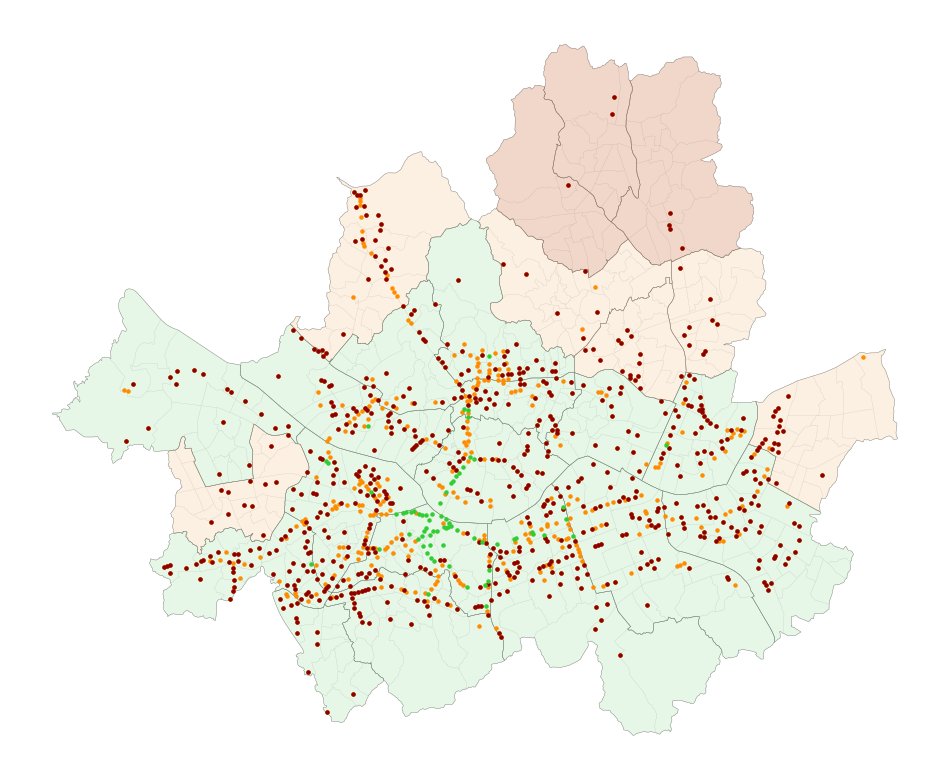

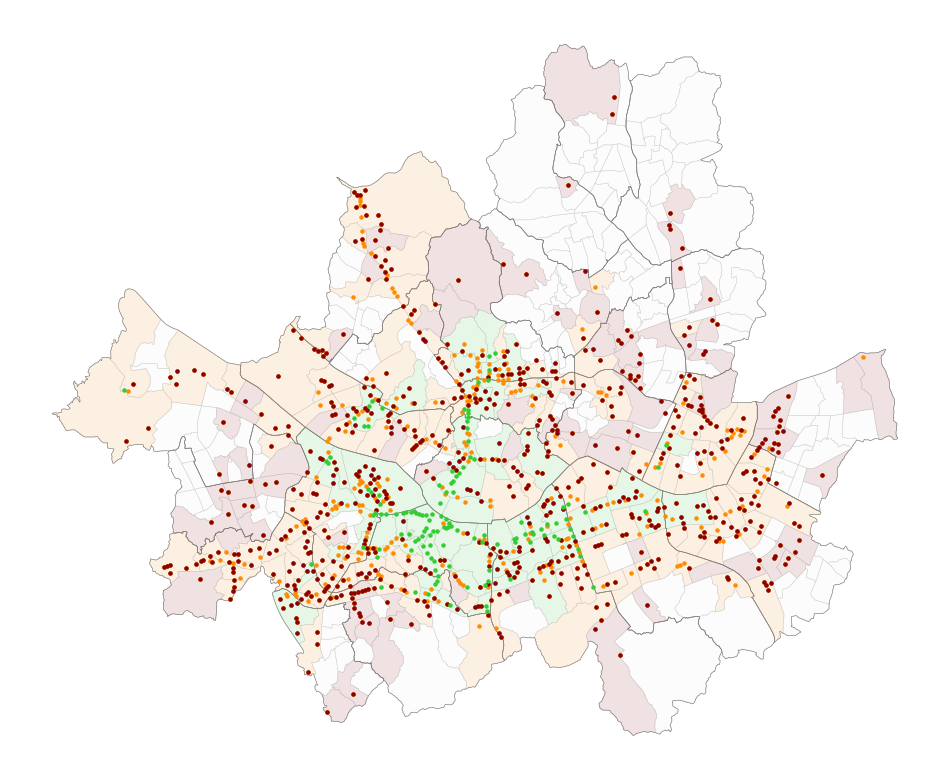

In [ ]:
# plot nodes_gdf
cmap1 = cm.get_cmap('rainbow')

norm_fixed = colors.Normalize(vmin=0, vmax=22)
# nodes_gdf.plot(figsize=(10, 10), markersize=5, cmap=cmap1, norm=norm_fixed, legend=True)

fig, ax = plt.subplots(figsize=(12, 12))

submunicipalities_gdf.plot(ax=ax, color='lightgrey', alpha=0.05)
submunicipalities_gdf.plot(ax=ax, color='none', edgecolor='lightgrey', linewidth=0.12)
municipalities_gdf.plot(ax=ax, color='none', edgecolor='grey', linewidth=0.3)

municipalities_gdf[municipalities_gdf['unique_participants'] <= 5].plot(ax=ax, color='darkorange', edgecolor='none', alpha=0.1)
municipalities_gdf[municipalities_gdf['unique_participants'] == 1].plot(ax=ax, color='darkred', edgecolor='none', alpha=0.1)
municipalities_gdf[municipalities_gdf['unique_participants'] > 5].plot(ax=ax, color='limegreen', edgecolor='none', alpha=0.1)

nodes_gdf[nodes_gdf['unique_participants'] <= 5].plot(ax=ax, markersize=5, color='darkorange')
nodes_gdf[nodes_gdf['unique_participants'] == 1].plot(ax=ax, markersize=5, color='darkred')
nodes_gdf[nodes_gdf['unique_participants'] > 5].plot(ax=ax, markersize=5, color='limegreen')

ax.set_axis_off()


fig, ax = plt.subplots(figsize=(12, 12))

submunicipalities_gdf.plot(ax=ax, color='lightgrey', alpha=0.05)
submunicipalities_gdf.plot(ax=ax, color='none', edgecolor='lightgrey', linewidth=0.3)
municipalities_gdf.plot(ax=ax, color='none', edgecolor='grey', linewidth=0.45)

submunicipalities_gdf[    (submunicipalities_gdf['unique_participants'] <= 5) &
    (submunicipalities_gdf['unique_participants'] > 1)].plot(ax=ax, color='darkorange', edgecolor='none', alpha=0.1)
submunicipalities_gdf[submunicipalities_gdf['unique_participants'] == 1].plot(ax=ax, color='darkred', edgecolor='none', alpha=0.1)
submunicipalities_gdf[submunicipalities_gdf['unique_participants'] == 0].plot(ax=ax, color='white', edgecolor='none', alpha=0.0)
submunicipalities_gdf[submunicipalities_gdf['unique_participants'] > 5].plot(ax=ax, color='limegreen', edgecolor='none', alpha=0.1)


nodes_gdf[nodes_gdf['unique_participants'] <= 3].plot(ax=ax, markersize=5, color='darkorange')
nodes_gdf[nodes_gdf['unique_participants'] == 1].plot(ax=ax, markersize=5, color='darkred')
nodes_gdf[nodes_gdf['unique_participants'] > 3].plot(ax=ax, markersize=5, color='limegreen')

ax.set_axis_off()

In [22]:
avg_participants_per_sub = (
    nodes_gdf.groupby('submuni_index')['unique_participants']
    .mean()
    .rename('avg_unique_participants')
)

submunicipalities_gdf = submunicipalities_gdf.join(avg_participants_per_sub, how='left')

In [23]:
avg_positions_per_sub = (
    nodes_gdf.groupby('submuni_index')['total_positions']
    .mean()
    .rename('avg_positions')
)

submunicipalities_gdf = submunicipalities_gdf.join(avg_positions_per_sub, how='left')

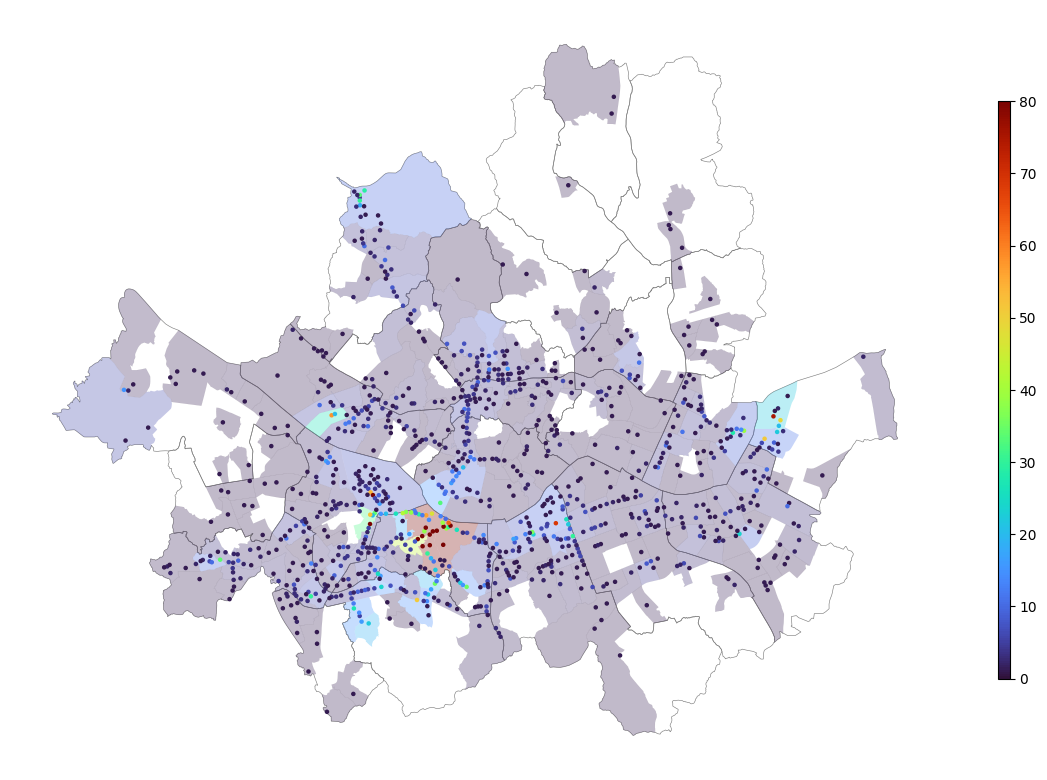

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))

norm_fixed = colors.Normalize(vmin=0, vmax=500)
norm_fixed2 = colors.Normalize(vmin=0, vmax=50)
norm_fixed3 = colors.Normalize(vmin=0, vmax=80)

legend_kwds={
        'shrink': 0.5,       # scale the height
        'aspect': 50,        # controls thickness
        'alpha': 1,        # transparency
    }
legend_kwds2={
        'shrink': 0.5,       # scale the height
        'aspect': 50,        # controls thickness
        'alpha': 0.3,        # transparency
    }

submunicipalities_gdf[submunicipalities_gdf['avg_positions'] <= 5].plot(ax=ax, color='none', edgecolor='lightgrey', linewidth=0.12, alpha=1)
municipalities_gdf.plot(ax=ax, color='none', edgecolor='grey', linewidth=0.45)
submunicipalities_gdf.plot(ax=ax, alpha=0.3, column='avg_positions', legend=False, cmap='turbo', norm=norm_fixed3, legend_kwds=legend_kwds2)
nodes_gdf.plot(ax=ax, alpha=1, column='total_positions', legend=True, cmap='turbo', markersize=5, norm=norm_fixed3, legend_kwds=legend_kwds)
ax.set_axis_off()

In [ ]:
from shapely.ops import nearest_points


nodes_grouped = nodes_gdf.copy()
positions_seoul_grouped = positions_with_nodes_all.copy()

def point_inside(pt, poly):
    if poly is None:
        return pt
    if poly.contains(pt):
        return pt
    return nearest_points(pt, poly)[1]


def weighted_point(pts, weights=None, poly=None):
    xs = np.array([p.x for p in pts], dtype=float)
    ys = np.array([p.y for p in pts], dtype=float)
    if weights is None:
        wx, wy = xs.mean(), ys.mean()
    else:
        w = np.array(weights, dtype=float)
        w[~np.isfinite(w)] = 0.0
        if w.sum() == 0:
            wx, wy = xs.mean(), ys.mean()
        else:
            wx = np.average(xs, weights=w)
            wy = np.average(ys, weights=w)
    return point_inside(Point(float(wx), float(wy)), poly)

muni_field = 'unique_participants'
submuni_field = 'avg_positions'

# AGGREGATION PIPELINE
next_node_id = int(nodes_grouped['node_id'].max()) + 1
id_map = {}
removed_nodes = set()
agg_rows = []


# ---------- RULES 1 & 2 over MUNICIPALITIES ----------
'''
Rule 1: If a municipality has only one node, keep that node.
Rule 2: If a municipality has less than 5 unique participants, aggregate the nodes into a single 'municipality' node.
'''
for m_idx, df_m in nodes_grouped.groupby('muni_index', dropna=False):
    node_ids = df_m['node_id'].tolist()
    if not node_ids:
        continue

    # Rule 1
    if len(node_ids) == 1:
        nid = node_ids[0]
        nodes_grouped.loc[nodes_grouped['node_id'] == nid, 'node_type'] = 'intersection_municipality'
        id_map.setdefault(nid, nid)
        print(f"Keeping single node {nid} in municipality {m_idx}")
        continue

    # Rule 2
    unique_participants = municipalities_gdf.loc[m_idx, 'unique_participants']
    if unique_participants < 5:
        poly = municipalities_gdf.loc[m_idx, 'geometry']
        pts = df_m.geometry.tolist()
        weights = df_m['unique_participants'].to_numpy()
        new_pt = weighted_point(pts, weights=weights, poly=poly)

        new_row = {
            'node_id': next_node_id,
            'geometry': new_pt,  
            'total_positions': df_m['total_positions'].sum(),
            'unique_participants': np.nan,
            'node_type': 'municipality',
            'muni_index': m_idx,
            'submuni_index': np.nan
        }
        for nid in node_ids:
            id_map[nid] = next_node_id
            removed_nodes.add(nid)
        agg_rows.append(new_row)
        next_node_id += 1

    print(f"Keeping {len(node_ids)} nodes in municipality {m_idx} with {unique_participants} unique participants")

remaining = nodes_grouped[nodes_grouped['node_type'].isna() & (~nodes_grouped['node_id'].isin(removed_nodes))].copy() # Remaining after municipalities


# ---------- RULES 3–6 over SUBMUNICIPALITIES ----------
'''
Rule 3: If a submunicipality has only one node, keep that node.
Rule 4: If a submunicipality has on average less than 14 total visits per node, aggregate the nodes into a single 'submunicipality' node.
Rule 5: If a submunicipality has on average less than or equal to 80 total visits per node, keep the current intersection nodes.
Rule 6: If a submunicipality has on average more than 80 total visits per node, keep the current intersection nodes, but give them a different type for later.
'''

# Global cache of main-geometry -> node_id that will exist in the final output --CHECK
global_main_by_wkt = {}

def register_main_node(geom, node_id):
    global_main_by_wkt[geom.wkt] = node_id


for s_idx, df_s in remaining.groupby('submuni_index', dropna=False):
    node_ids = df_s['node_id'].tolist()
    if not node_ids:
        continue

    poly = submunicipalities_gdf.loc[s_idx, 'geometry']

    # Rule 3
    if len(node_ids) == 1:
        nid = node_ids[0]
        remaining.loc[remaining['node_id'] == nid, 'node_type'] = 'intersection_submunicipality'
        id_map.setdefault(nid, nid)
        continue

    avg_positions = submunicipalities_gdf.loc[s_idx, 'avg_positions']

    # Rule 4
    if avg_positions < 14:
        pts = df_s.geometry.tolist()
        weights = df_s['total_positions'].to_numpy()
        new_pt = weighted_point(pts, weights=weights, poly=poly)
        new_row = {
            'node_id': next_node_id,
            'geometry': new_pt,
            'total_positions': df_s['total_positions'].sum(),
            'unique_participants': np.nan,
            'node_type': 'submunicipality',
            'muni_index': df_s['muni_index'].tolist()[0],
            'submuni_index': s_idx
        }
        for nid in node_ids:
            id_map[nid] = next_node_id
            removed_nodes.add(nid)
        agg_rows.append(new_row)
        next_node_id += 1
        continue

    # Rule 5

    if avg_positions <= 80:
        # 1) Get MAIN intersections inside this submunicipality (fallback: all mains if none inside)
        main_in_poly = intersections_gdf[intersections_gdf.within(poly)]
        if main_in_poly.empty:
            main_geoms = list(intersections_gdf.geometry)   # fallback: all main intersections
        else:
            main_geoms = list(main_in_poly.geometry)

        if len(main_geoms) == 0:
            # extreme fallback: no mains at all -> just keep current nodes
            remaining.loc[remaining['node_id'].isin(node_ids), 'node_type'] = 'intersection'
            for nid in node_ids:
                id_map.setdefault(nid, nid)
            continue

        main_tree = STRtree(main_geoms)

        # 2) Map each combined node in this submunicipality to its nearest MAIN
        grouped_by_main_wkt = {}   # main_wkt -> {"geom": main_geom, "nids": [old_ids]}
        for nid in node_ids:
            old_geom = remaining.loc[remaining["node_id"] == nid, "geometry"].iloc[0]
            nearest_idx = int(main_tree.nearest(old_geom))
            main_geom = main_geoms[nearest_idx]
            key = main_geom.wkt
            if key not in grouped_by_main_wkt:
                grouped_by_main_wkt[key] = {"geom": main_geom, "nids": []}
            grouped_by_main_wkt[key]["nids"].append(nid)

        # 3) Reuse existing rows at MAIN intersections if possible; create a new row if not
        existing_by_wkt = {g.wkt: nid for nid, g in zip(remaining["node_id"], remaining["geometry"])}

        for main_wkt, pack in grouped_by_main_wkt.items():
            main_geom = pack["geom"]
            group_nids = pack["nids"]

            if main_wkt in existing_by_wkt:
                # Reuse the existing node already at this MAIN
                new_nid = int(existing_by_wkt[main_wkt])
                remaining.loc[remaining["node_id"] == new_nid, "node_type"] = "intersection"
            else:
                # Create one new node row for this MAIN
                new_nid = next_node_id
                next_node_id += 1
                agg_rows.append({
                    "node_id": new_nid,
                    "geometry": main_geom,
                    "total_positions": remaining[remaining["node_id"].isin(group_nids)]["total_positions"].sum(),
                    "unique_participants": np.nan,
                    "node_type": "intersection",
                    "muni_index": df_s["muni_index"].iloc[0],
                    "submuni_index": s_idx
                })
                existing_by_wkt[main_wkt] = new_nid

            # Remap all old node_ids in this group to the chosen MAIN node_id
            for old_id in group_nids:
                if old_id != new_nid:
                    id_map[old_id] = new_nid
                    removed_nodes.add(old_id)

        # mark the originals as processed (they’ll be dropped later when building parts)
        remaining.loc[remaining['node_id'].isin(node_ids), 'node_type'] = 'intersection'
        continue

    # Rule 6
    if avg_positions > 80:
        # High-activity submunicipality: keep ALL nodes (main + local) as-is,
        # just tag them with a special type so we know they're "detailed"
        remaining.loc[remaining['node_id'].isin(node_ids), 'node_type'] = 'submunicipality_detailed'
        for nid in node_ids:
            id_map.setdefault(nid, nid)  
        continue

Keeping 19 nodes in municipality 0.0 with 3 unique participants
Keeping 71 nodes in municipality 1.0 with 12 unique participants
Keeping 68 nodes in municipality 2.0 with 17 unique participants
Keeping 99 nodes in municipality 3.0 with 21 unique participants
Keeping 49 nodes in municipality 4.0 with 13 unique participants
Keeping 105 nodes in municipality 5.0 with 22 unique participants
Keeping 110 nodes in municipality 6.0 with 20 unique participants
Keeping 14 nodes in municipality 7.0 with 9 unique participants
Keeping 68 nodes in municipality 8.0 with 11 unique participants
Keeping 19 nodes in municipality 9.0 with 8 unique participants
Keeping 13 nodes in municipality 10.0 with 3 unique participants
Keeping 65 nodes in municipality 11.0 with 15 unique participants
Keeping 24 nodes in municipality 12.0 with 12 unique participants
Keeping 39 nodes in municipality 13.0 with 4 unique participants
Keeping 4 nodes in municipality 14.0 with 1 unique participants
Keeping 2 nodes in munici

In [26]:
# ---------- BUILD UPDATED NODES ----------
processed1 = nodes_grouped[(nodes_grouped['node_type'].notna()) & (~nodes_grouped['node_id'].isin(removed_nodes))].copy()
processed2 = remaining[~remaining['node_id'].isin(removed_nodes)].copy()

parts = [processed1, processed2]

if agg_rows:
    agg_df = pd.DataFrame(agg_rows)
    agg_gdf = gpd.GeoDataFrame(agg_df, geometry='geometry', crs=nodes_grouped.crs)
    parts.append(agg_gdf)

nodes_grouped = pd.concat(parts, ignore_index=True)
nodes_grouped = gpd.GeoDataFrame(nodes_grouped, geometry='geometry', crs=nodes_grouped.crs)


def remap_node_id(val):
    if pd.isna(val):
        return val
    try:
        return id_map.get(int(val), int(val))
    except Exception:
        return val

positions_seoul_grouped['node_id'] = positions_seoul_grouped['node_id'].apply(remap_node_id)

missing_after_first_remap = positions_seoul_grouped.loc[
    positions_seoul_grouped['node_id'].isna(), ['id_participant','merged_datetime']
]
print(f"[CHECK] Missing after first remap: {len(missing_after_first_remap)}")


[CHECK] Missing after first remap: 0


In [27]:
old_ids_in_order = nodes_grouped['node_id'].drop_duplicates().tolist()
id_remap = {old: new for new, old in enumerate(old_ids_in_order)}

nodes_grouped['node_id_old'] = nodes_grouped['node_id']
nodes_grouped['node_id'] = nodes_grouped['node_id'].map(id_remap).astype(int)
positions_seoul_grouped['node_id_old'] = positions_seoul_grouped['node_id']

def map_pos_id(x):
    if pd.isna(x):
        return pd.NA
    try:
        return id_remap.get(int(x), pd.NA)
    except Exception:
        return pd.NA

positions_seoul_grouped['node_id'] = positions_seoul_grouped['node_id'].apply(map_pos_id).astype('Int64')

unmapped_ids = set(
    positions_seoul_grouped.loc[positions_seoul_grouped['node_id'].isna(),'node_id_old']
    .dropna().astype(int).unique()
)
print(f"[CHECK] Unmapped old ids after renumber: {len(unmapped_ids)} -> {sorted(list(unmapped_ids))[:10]} ...")
present_final_ids = set(nodes_grouped['node_id_old'].astype(int).unique())
print(f"[CHECK] Any unmapped olds not in final nodes? {bool(unmapped_ids - present_final_ids)}")

[CHECK] Unmapped old ids after renumber: 1 -> [np.int64(624)] ...
[CHECK] Any unmapped olds not in final nodes? True


In [28]:
# QUICK FIX ---- CHECK
# assign any NaN node_ids to the nearest MAIN node (fallback: any node) ---

# which node_types count as "main" in your final nodes table
MAIN_TYPES = {"intersection", "intersection_municipality", "intersection_submunicipality"}

na_mask = positions_seoul_grouped["node_id"].isna()
n_missing_before = int(na_mask.sum())
print(f"[quick-fix] positions with NaN node_id before fix: {n_missing_before}")

if n_missing_before > 0:
    # 1) try to use only main-type nodes
    mains = nodes_grouped[nodes_grouped["node_type"].isin(MAIN_TYPES)].copy()

    # fallback: if you somehow have no explicit main nodes tagged, use all nodes
    if mains.empty:
        print("[quick-fix] No nodes with main types found; falling back to ALL nodes.")
        mains = nodes_grouped.copy()

    # Build a spatial index for nearest lookups
    main_geoms = list(mains.geometry)
    main_ids   = list(mains["node_id"].astype(int))
    from shapely.strtree import STRtree
    tree = STRtree(main_geoms)

    # map geometry -> node_id (use WKT key because STRtree returns geometry objects)
    wkt2id = {geom.wkt: nid for geom, nid in zip(main_geoms, main_ids)}

    # Assign nearest main node_id to each NaN position
    for idx, pt in positions_seoul_grouped.loc[na_mask, "geometry"].items():
        nearest_geom_id = tree.nearest(pt)
        nearest_geom = main_geoms[nearest_geom_id]
        new_id = wkt2id[nearest_geom.wkt]
        positions_seoul_grouped.at[idx, "node_id"] = new_id

    # keep it as nullable int (Int64) going forward
    positions_seoul_grouped["node_id"] = positions_seoul_grouped["node_id"].astype("Int64")

n_missing_after = int(positions_seoul_grouped["node_id"].isna().sum())
print(f"[quick-fix] positions with NaN node_id after fix: {n_missing_after}")

[quick-fix] positions with NaN node_id before fix: 44
[quick-fix] positions with NaN node_id after fix: 0


In [29]:
# final checks

nodes_set = set(nodes_grouped['node_id'].astype(int).unique())
pos_set   = set(positions_seoul_grouped['node_id'].dropna().astype(int).unique())

missing_in_nodes = pos_set - nodes_set
if missing_in_nodes:
    print("Warning: some remapped position node_ids not present in nodes_grouped:", sorted(missing_in_nodes))

# Check contiguous 0..N-1
max_id = nodes_grouped['node_id'].max()
expected = set(range(max_id + 1))
if nodes_set != expected:
    print("Warning: node IDs are not perfectly contiguous:", sorted(nodes_set ^ expected))

print("Renumbered nodes from", len(old_ids_in_order), "unique IDs to", max_id + 1, "sequential IDs (0..N-1).")

Renumbered nodes from 271 unique IDs to 271 sequential IDs (0..N-1).


In [30]:
# creating a node gdf with the node coordinates and id
nodes = gpd.GeoDataFrame(
    nodes_grouped,
    geometry= gpd.points_from_xy(
        nodes_grouped.geometry.x, 
        nodes_grouped.geometry.y
    ),
    crs=nodes_grouped.crs
)

# creating node x and node y fields
nodes['node_x'] = nodes.geometry.x
nodes['node_y'] = nodes.geometry.y

nodes.drop(columns=['node_id_old'], inplace=True)

In [31]:
#updating the speed field
positions_seoul_grouped['prev_lat'] = positions_seoul_grouped.groupby('id_participant')['latitude'].shift()
positions_seoul_grouped['prev_lon'] = positions_seoul_grouped.groupby('id_participant')['longitude'].shift()
positions_seoul_grouped['prev_time'] = positions_seoul_grouped.groupby('id_participant')['merged_datetime'].shift()
positions_seoul_grouped['time_diff'] = (positions_seoul_grouped['merged_datetime'] - positions_seoul_grouped['prev_time']).dt.total_seconds()
positions_seoul_grouped['geo_distance'] = positions_seoul_grouped.apply(
    lambda row: geodesic((row['latitude'], row['longitude']), 
                         (row['prev_lat'], row['prev_lon'])
                        ).meters if pd.notnull(row['prev_lat']) and pd.notnull(row['prev_lon']) else 0,
    axis=1
)
positions_seoul_grouped['speed'] = positions_seoul_grouped['geo_distance'] / positions_seoul_grouped['time_diff']

# set nan speed values to 0
positions_seoul_grouped['speed'].fillna(0, inplace=True)

C:\Users\Michele\AppData\Local\Temp\ipykernel_15480\875610752.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  positions_seoul_grouped['speed'].fillna(0, inplace=True)


In [32]:
positions_links = positions_seoul_grouped[['id_participant','merged_datetime', 'node_id', 'speed']].copy()

positions_links['node_id'] = positions_links['node_id'].astype(int)
positions_links['prev_node_id'] = positions_links.groupby('id_participant')['node_id'].shift(1)
positions_links = positions_links.dropna(subset=['prev_node_id'])
positions_links['prev_node_id'] = positions_links['prev_node_id'].astype(int)
positions_links['id_participant'] = positions_links["id_participant"].str.extract(r'arda(\d+)').astype(int)

In [ ]:
nodes.to_csv(os.path.join(BASE_DIR,"graph_components/graph_components_intersections/nodes_detailed.csv"))
nodes.to_file(os.path.join(BASE_DIR,"graph_components/graph_components_intersections/nodes_detailed.shp"))
positions_links.to_csv(os.path.join(BASE_DIR,"graph_components/graph_components_intersections/positions_links_detailed.csv"))

C:\Users\Michele\AppData\Local\Temp\ipykernel_13236\3838024822.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap1 = cm.get_cmap('rainbow')
C:\Users\Michele\AppData\Local\Temp\ipykernel_13236\3838024822.py:18: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  municipalities_gdf[municipalities_gdf['total_positions'] == 0].plot(ax=ax1_muni, color='lightgrey', edgecolor='black')


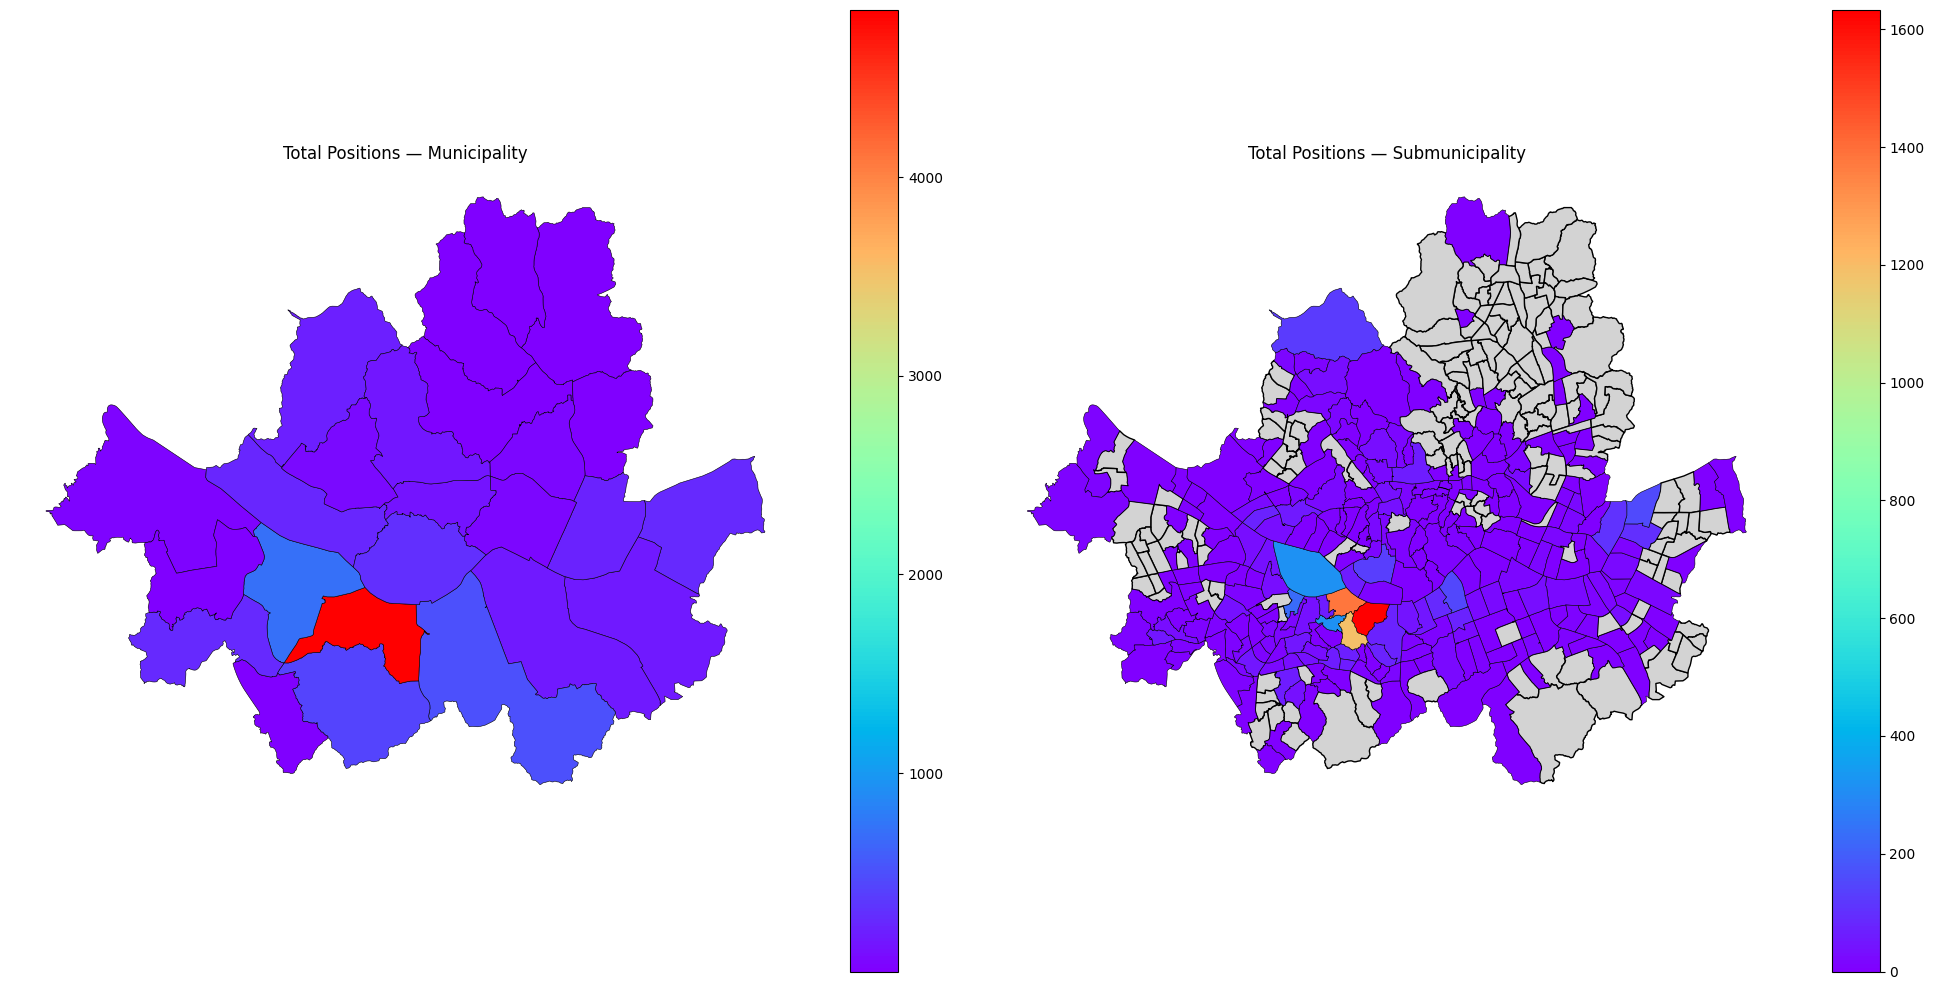

C:\Users\Michele\AppData\Local\Temp\ipykernel_13236\3838024822.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap2 = cm.get_cmap('rainbow')
C:\Users\Michele\AppData\Local\Temp\ipykernel_13236\3838024822.py:46: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  municipalities_gdf[municipalities_gdf['unique_participants'] == 0].plot(ax=ax2_muni, color='lightgrey', edgecolor='black')


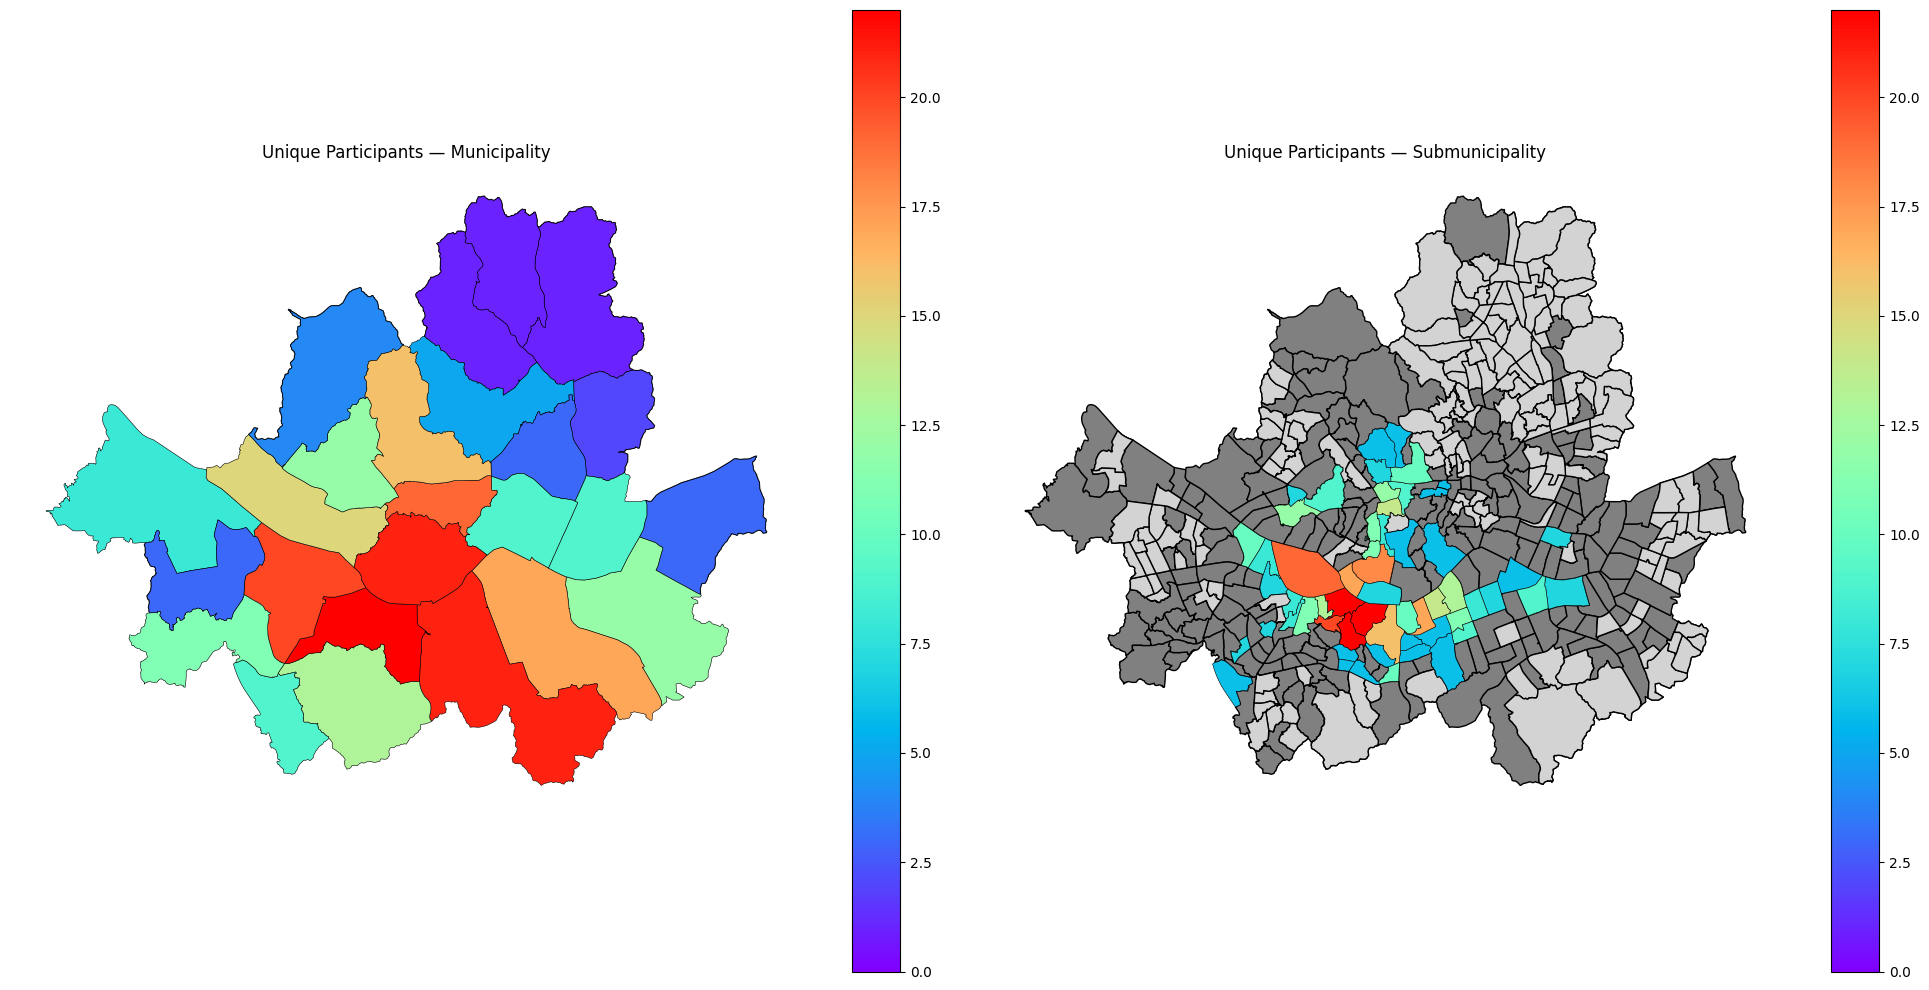

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm

# ----------------------------
# PLOT 1: Total Positions
# ----------------------------
fig1, (ax1_muni, ax1_submuni) = plt.subplots(1, 2, figsize=(20, 10))
cmap1 = cm.get_cmap('rainbow')

# Normalize based on non-zero values
norm_muni1 = colors.Normalize(vmin=municipalities_gdf[municipalities_gdf['total_positions'] >= 0]['total_positions'].min(),
                              vmax=municipalities_gdf['total_positions'].max())
norm_sub1 = colors.Normalize(vmin=submunicipalities_gdf[submunicipalities_gdf['total_positions'] >= 0]['total_positions'].min(),
                             vmax=submunicipalities_gdf['total_positions'].max())

# Municipalities
municipalities_gdf[municipalities_gdf['total_positions'] == 0].plot(ax=ax1_muni, color='lightgrey', edgecolor='black')
municipalities_gdf[municipalities_gdf['total_positions'] > 0].plot(
    column='total_positions', cmap=cmap1, linewidth=0.4, ax=ax1_muni, edgecolor='black', norm=norm_muni1, legend=True
)
ax1_muni.set_title('Total Positions — Municipality')
ax1_muni.axis('off')

# Submunicipalities
submunicipalities_gdf[submunicipalities_gdf['total_positions'] == 0].plot(ax=ax1_submuni, color='lightgrey', edgecolor='black')
submunicipalities_gdf[submunicipalities_gdf['total_positions'] > 0].plot(
    column='total_positions', cmap=cmap1, linewidth=0.4, ax=ax1_submuni, edgecolor='black', norm=norm_sub1, legend=True
)
ax1_submuni.set_title('Total Positions — Submunicipality')
ax1_submuni.axis('off')

plt.tight_layout()
plt.show()

# ----------------------------
# PLOT 2: Unique Participants
# ----------------------------
fig2, (ax2_muni, ax2_submuni) = plt.subplots(1, 2, figsize=(20, 10))
cmap2 = cm.get_cmap('rainbow')
norm_fixed = colors.Normalize(vmin=0, vmax=22)

# Municipalities

municipalities_gdf[municipalities_gdf['unique_participants'] < 5].plot(ax=ax2_muni, color='grey', edgecolor='black')
municipalities_gdf[municipalities_gdf['unique_participants'] == 0].plot(ax=ax2_muni, color='lightgrey', edgecolor='black')
municipalities_gdf[municipalities_gdf['unique_participants'] > 0].plot(
    column='unique_participants', cmap=cmap2, linewidth=0.4, ax=ax2_muni, edgecolor='black', norm=norm_fixed, legend=True
)
ax2_muni.set_title('Unique Participants — Municipality')
ax2_muni.axis('off')

# Submunicipalities
# submunicipalities_gdf[submunicipalities_gdf['unique_participants'] <= 5].plot(ax=ax2_submuni, color='grey', edgecolor='black')
submunicipalities_gdf[submunicipalities_gdf['unique_participants'] == 0].plot(ax=ax2_submuni, color='lightgrey', edgecolor='black')

submunicipalities_gdf[submunicipalities_gdf['unique_participants'] > 0].plot(
    column='unique_participants', cmap=cmap2, linewidth=0.4, ax=ax2_submuni, edgecolor='black', norm=norm_fixed, legend=True
)
ax2_submuni.set_title('Unique Participants — Submunicipality')
ax2_submuni.axis('off')

plt.tight_layout()
plt.show()